Project 1: Text Classification (100 Points)
=============

In this problem set, based in part on Jacob Eisenstein's project of a similar name, you will build a system for automatically classifying headlines as being fake news or real news. You will:

- Do some basic text processing, tokenizing your input and converting it into a bag-of-words representation
- Build a machine learning classifier based on the generative model, using Naive Bayes
- Evaluate your classifiers and examine what they have learned
- Build a machine learning classifier based on the discriminative model, using Perceptron
- Build a logistic regression classifier using PyTorch
- Implement techniques to improve your classifier, and compete with your classmates!

# 0. Setup

In order to develop this assignment, you will need at least [python 3.6](https://www.python.org/downloads/) and the following libraries. The best way to get all of it is to install [anaconda](https://www.continuum.io/downloads), so a good starting point would be to install that.

- [jupyter](http://jupyter.readthedocs.org/en/latest/install.html)
- numpy (This will come if you install scipy like above, but if not install separately)
- [matplotlib](http://matplotlib.org/users/installing.html)
- [nosetests](https://nose.readthedocs.org/en/latest/)
- [pytest](https://docs.pytest.org/en/7.4.x/)
- [pandas](http://pandas.pydata.org/) Dataframes

If there are any packages not included, you can install them with ``conda install <package_name>``. 

You can also access the [indigo](https://indigo.cs.oswego.edu/jupyter) server and work there, though this has not yet been thorougly tested!

## About this assignment

- This is a Jupyter notebook. You can execute cell blocks by pressing control-enter.
- Most of your coding will be in the python source files in the directory ```oswegonlp```.
- The directory ```tests``` contains unit tests that will be used to grade your assignment, using ```nosetests```. You should run them as you work on the assignment to see that you're on the right track. You are free to look at their source code, if that helps -- though most of the relevant code is also here in this notebook. Learn more about running unit tests at http://pythontesting.net/framework/nose/nose-introduction/
- You may want to add more tests, but that is completely optional. 
- **To submit this assignment, run the script ```make-submission.sh```, and submit the tarball ```project1-submission.tgz``` on Blackboard.**

In [1]:
import sys
from importlib import reload

In [2]:
print('My Python version')

print('python: {}'.format(sys.version))

My Python version
python: 3.11.7 | packaged by conda-forge | (main, Dec 23 2023, 14:43:09) [GCC 12.3.0]


In [3]:
import pytest

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
from torch import optim

%matplotlib inline

In [4]:
print('My library versions')

print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('scipy: {}'.format(sp.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('pytest: {}'.format(pytest.__version__))
print('torch: {}'.format(torch.__version__))

My library versions
pandas: 2.2.0
numpy: 1.26.3
scipy: 1.12.0
matplotlib: 3.8.2
pytest: 7.4.4
torch: 2.1.2+cu121


To test whether your libraries are the right version, run:

`python -m pytest tests/test_environment.py`

In [5]:
# use ! to run shell commands in notebook
! python -m pytest tests/test_environment.py

============================= test session starts ==============================
platform linux -- Python 3.11.7, pytest-7.4.4, pluggy-1.4.0
rootdir: /home/dschlege/teaching/csc350/Project1
plugins: anyio-4.2.0
collected 1 item                                                               

tests/test_environment.py .                                              [100%]

============================== 1 passed in 1.65s ===============================


# 1. Preprocessing

Total: 10 points

Read the data into a dataframe

In [369]:
df_train = pd.read_csv('fakenews-train.csv')

A dataframe is a structured representation of your data. You can preview a dataframe using `head()`

In [370]:
df_train.head()

,Headline,RealOrFake
0,donald trump do you remember the year since he...,real
1,trump defends son over emails as moscow hits back,real
2,donald trump strategist says media wont easily...,real
3,anthony scaramucci who is donald trumps new co...,real
4,donald trumps mobile phone use worries securit...,real


## Bags of words

Your first task is to convert the text to a bag-of-words representation. For this data, a lot of the preprocessing is already done: the text is lower-cased, and punctuation is removed. You need only create a `counter` for each headline.

- **Deliverable 1.1**: Complete the function `oswegonlp.preprocessing.bag_of_words`. (2.5 points)
- **Test**: `nose tests/test_preproc.py:test_d1_1_bow`

In [371]:
from oswegonlp import preprocessing

In [372]:
# run this block to update the notebook as you change the preproc library
reload(preprocessing);

In [373]:
y_tr,x_tr = preprocessing.read_data('fakenews-train.csv',preprocessor=preprocessing.bag_of_words)
y_dv,x_dv = preprocessing.read_data('fakenews-dev.csv',preprocessor=preprocessing.bag_of_words)

In [374]:
# I'll use this one!
#y_te,x_te = preprocessing.read_data('fakenews-test.csv',preprocessor=preprocessing.bag_of_words)
# But yours has hidden labels!
y_te,x_te = preprocessing.read_data('fakenews-test-hidden.csv',preprocessor=preprocessing.bag_of_words)

## Unseen words

One challenge for classification is that words will appear in the test data that do not appear in the training data. Compute the number of words that appear in `fakenews-dev.csv`, but not in `fakenews-train.csv`. To do this, implement the following deliverables:

- **Deliverable 1.2**: implement `oswegonlp.preprocessing.aggregate_counts`, a counter of all words in a list of bags-of-words.  (2.5 points)
- **Deliverable 1.3**: implement `oswegonlp.preprocessing.compute_oov`, returning a list of words that appear in one list of bags-of-words, but not another.  (2.5 points)
- **Tests**: `tests/test_preproc.py:test_d1_2_agg`, `tests/test_preproc.py:test_d1_3a_oov`

In [375]:
from collections import Counter

In [376]:
reload(preprocessing);

To write fast code, you can find bottlenecks using the %%timeit cell magic. 

In [377]:
%%timeit
preprocessing.aggregate_word_counts(x_tr)

338 ms ± 52.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [378]:
counts_dv = preprocessing.aggregate_word_counts(x_dv)

You can see the most common items in a counter by calling `counts.most_common()`:

In [379]:
counts_dv.most_common(5)

[('trump', 308), ('donald', 103), ('to', 97), ('the', 63), ('on', 50)]

In [380]:
counts_tr = preprocessing.aggregate_word_counts(x_tr)

In [381]:
len(preprocessing.compute_oov(counts_dv,counts_tr))

322

In [382]:
len(preprocessing.compute_oov(counts_tr,counts_dv))

3739

In [383]:
preprocessing.oov_rate(counts_dv,counts_tr)

0.24357034795763993

24% of the words in the dev set do not appear in the training set.

## Power laws

Word count distributions are said to follow [power law](https://en.wikipedia.org/wiki/Power_law) distributions. 

In practice, this means that a log-log plot of frequency against rank is nearly linear. Let's see if this holds for our data.

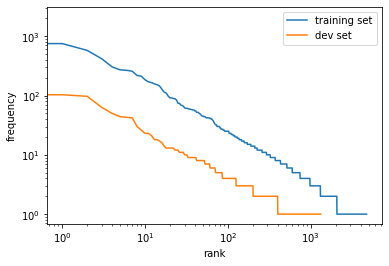

In [384]:
plt.loglog([val for word,val in counts_tr.most_common()])
plt.loglog([val for word,val in counts_dv.most_common()])
plt.xlabel('rank')
plt.ylabel('frequency')
plt.legend(['training set','dev set']);

**Reflect**: The dataset we are working with does not include capitalization. How do you think this figure would change if capitalization distinctions were included?

## Pruning the vocabulary

Let's prune the vocabulary to include only words that appear at least ten times in the training data.

- **Deliverable 1.4:** Implement `oswegonlp.preprocessing.prune_vocabulary` (2.5 points)
- **Test**: `tests/test_preproc.py:test_d1_4_prune`

In [385]:
reload(preprocessing);

In [386]:
x_tr_pruned, vocab = preprocessing.prune_vocabulary(counts_tr,x_tr,5)
x_dv_pruned, _ = preprocessing.prune_vocabulary(counts_tr,x_dv,5)
x_te_pruned, _ = preprocessing.prune_vocabulary(counts_tr,x_te,5)

In [387]:
len(vocab)

744

In [388]:
i = 300
print(len(x_dv[i]),len(x_dv_pruned[i]))
print(sum(x_dv[i].values()),sum(x_dv_pruned[i].values()))

8 6
8 6


# 2. Linear classification

Now you'll implement the linear classification rule, $\hat{y} = \text{argmax}_{y \in \mathcal{Y}} \theta \cdot f(x,y)$.

You will use these functions in all classifiers in this assignment.

Total: 16.5 points

In [389]:
from oswegonlp import classifier_base
reload(classifier_base)

from oswegonlp import constants
reload(constants);

Recall from class and the reading that the feature function vector $f(x,y)$ can be viewed as a dict, in which the values are counts, and the keys are tuples $(y,x_j)$, where $y$ is a label and $x_j$ is a base feature.

- **Deliverable 2.1**: Implement the function ```make_feature_vector``` in ```classifier_base.py```. (7.5 points)
- **Test**: `tests/test_classifier.py:test_d2_1_featvec`

Note that you must also include the offset feature, ```oswegonlp.constants.OFFSET```.

Desired output is shown below:

In [390]:
fv = classifier_base.make_feature_vector({'test':1,'case':2},'fake')

In [391]:
print(fv)

{('fake', '**OFFSET**'): 1, ('fake', 'test'): 1, ('fake', 'case'): 2}


Let's compute the entire set of labels.

In [392]:
labels = set(y_tr) #figure out all possible labels
print(labels)

{'fake', 'real'}


Now implement the prediction rule, $\hat{y} = \text{argmax}_{y \in \mathcal{Y}} \theta \cdot f(x,y)$..

- **Deliverable 2.2**: Implement the function ```predict``` in ```classifier_base.py```. (9 points)
- **Test**: `tests/test_classifier.py:test_d2_2_predict`

The output should be:

- A predicted label
- The scores of all labels

This function will be called **a lot**, so try to make it fast. You don't need to do anything crazy, but avoid making your code do silly extra work. It's worth trying out a couple different versions using %%timeit.

You can test this function using these simple hand-crafted weights.

In [393]:
from collections import defaultdict

In [394]:
# weight vectors must be defaultdicts
theta_manual = {('fake','media'):0.2,
                ('fake','hillary'):0.1,
                ('fake','obama'):0.2,
                ('real','signs'):0.3,
                ('real','tweets'):0.1,
                ('real','travel'):0.2,
                ('real',constants.OFFSET):0.01}

In [395]:
x_tr_pruned[58]

Counter({'donald': 1,
         'trump': 1,
         'hillary': 1,
         'clinton': 1,
         'final': 1,
         'debate': 1})

In [396]:
classifier_base.predict(x_tr_pruned[58],theta_manual,labels)

('fake', {'fake': 0.1, 'real': 0.01})

Now let's see how good these weights are, by evaluating on the dev set.

In [397]:
from oswegonlp import evaluation
reload(evaluation);

In [398]:
# this applies your predict function to all the instances in ```x_dv```
y_hat = classifier_base.predict_all(x_dv_pruned,theta_manual,labels)
print(evaluation.acc(y_hat,y_dv))

0.6554878048780488


# 3. Naive Bayes

You'll now implement a Naive Bayes classifier, as described in chapter 2 of the text.

Total: 20 points

In [407]:
from oswegonlp import naive_bayes
reload(naive_bayes);

- **Deliverable 3.1**: (warmup) implement ```corpus_counts``` in ```naive_bayes.py```. (5 points)
- **Test**: `tests/test_classifier.py:test_d3_1_corpus_counts`

This function should compute the word counts for a given label.

In [400]:
fake_counts = naive_bayes.corpus_counts(x_tr_pruned,y_tr,"fake");
print(fake_counts['news'])
print(fake_counts['tweet'])

25
5


- **Deliverable 3.2**: Implement ```estimate_pxy``` in ```naive_bayes.py```. (5 points)
- **Test**: `tests/test_classifier.py:test_d3_2_pxy`

This function should compute the *smoothed* multinomial distribution $\log P(x \mid y)$ for a given label $y$.

Hint: note that this function takes the vocabulary as an argument. You have to assign a probability even for words that do not appear in documents with label $y$, if they are in the vocabulary.

You can use ```get_corpus_counts``` in this function if you want to, but you don't have to.

In [401]:
log_pxy = naive_bayes.estimate_pxy(x_tr_pruned,y_tr,"fake",0.1,vocab)

Probabilities must sum to one! (or very close)

In [402]:
sum(np.exp(list(log_pxy.values())))

1.0000000000000016

Let's look at the log-probabilities of the words from the hand-tuned weights

In [403]:
print({word:log_pxy[word] for (_,word),weight in theta_manual.items() if weight>0})

{'media': -5.841019115574385, 'hillary': -4.2885868402631075, 'obama': -5.340637450969477, 'signs': -7.849449621611032, 'tweets': -6.888987671423739, 'travel': -11.283436826096178, '**OFFSET**': 0.0}


In [404]:
log_pxy_more_smooth = naive_bayes.estimate_pxy(x_tr_pruned,y_tr,"fake",10,vocab)

In [405]:
print({word:log_pxy_more_smooth[word] for (_,word),weight in theta_manual.items() if weight>0})

{'media': -6.140080457800395, 'hillary': -4.857464526155346, 'obama': -5.765387008358985, 'signs': -7.071638661805339, 'tweets': -6.746216261370711, 'travel': -7.33400292627283, '**OFFSET**': 0.0}


- **Deliverable 3.3**: Now you are ready to implement ```estimate_nb``` in ```naive_bayes.py```. (5 points)
- **Test**: `tests/test_classifier.py:test_d3_3a_nb`



- The goal is that the score given by ```classifier_base.predict``` is equal to the joint probability $P(x,y)$, as described in the notes.
- Don't forget the offset feature, whose weights should be set to the prior $\log P(y)$.
- The log-probabilities for the offset feature should not be smoothed.
- You can call the functions you have defined above, but you don't have to.

In [408]:
theta_nb = naive_bayes.estimate_nb(x_tr_pruned,y_tr,0.1)

In [184]:
classifier_base.predict(x_tr_pruned[155],theta_nb,labels)

('real', {'fake': -34.51928278596063, 'real': -29.09112908959238})

In [185]:
y_hat = classifier_base.predict_all(x_dv_pruned,theta_nb,labels)
print(evaluation.acc(y_hat,y_dv))

0.8170731707317073


In [186]:
# this block shows how we write and read predictions for evaluation
evaluation.write_predictions(y_hat,'nb-dev.preds')
y_hat_dv = evaluation.read_predictions('nb-dev.preds')
evaluation.acc(y_hat_dv,y_dv)

0.8170731707317073

In [187]:
# execute this block to write predictions for the test set
y_hat = classifier_base.predict_all(x_te_pruned,theta_nb,labels)
evaluation.write_predictions(y_hat,'nb-test.preds')

In [188]:
# you can't run this, but this how the grading code works
y_hat_te = evaluation.read_predictions('nb-test.preds')
evaluation.acc(y_hat_te,y_te)

0.8279569892473119

- **Deliverable 3.4**: Write a function in ```naive_bayes.py``` called ```find_best_smoother```, which finds the smoothing value that gives best performance on the dev data.  (5 points)
- **Test**: `tests/test_classifier.py:test_d3_4a_nb_best`

Your function should trying at least the following values in `vals` below.

Then, using this smoothing value, run your Naive Bayes classifier on the test set, and output the results.

In [189]:
vals = np.logspace(-3,2,11)
print(vals)

[1.00000000e-03 3.16227766e-03 1.00000000e-02 3.16227766e-02
 1.00000000e-01 3.16227766e-01 1.00000000e+00 3.16227766e+00
 1.00000000e+01 3.16227766e+01 1.00000000e+02]


In [409]:
best_smoother, scores = naive_bayes.find_best_smoother(x_tr_pruned,y_tr,x_dv_pruned,y_dv,vals)

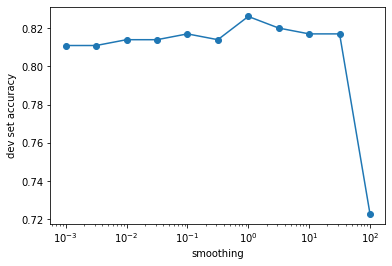

In [191]:
plt.semilogx(list(scores.keys()),list(scores.values()),'o-');
plt.xlabel('smoothing')
plt.ylabel('dev set accuracy');

**Reflect:**

- what might explain the dramatic drop in accuracy when the smoothing is increased from $10$ to $30$?
- before you check, predict whether the accuracy will continue to significantly drop if you further increase the smoothing to $10000$.

In [410]:
theta_nb = naive_bayes.estimate_nb(x_tr_pruned,y_tr,best_smoother)
y_hat = classifier_base.predict_all(x_te_pruned,theta_nb,labels)
evaluation.write_predictions(y_hat,'nb-best-test.preds')

In [193]:
# you can't run this
y_hat = evaluation.read_predictions('nb-best-test.preds')
print(evaluation.acc(y_hat,y_te))

0.837173579109063


# 4. Perceptron 

Total: 18 points

The perceptron update is,

\begin{align}
\hat{y} \gets & \text{argmax}_{y \in \mathcal{Y}} \theta \cdot f(x,y)\\
\theta \gets & \theta + f(x,y) - f(x,\hat{y})
\end{align}

You will now implement this classifier, using the file ```oswegonlp/perceptron.py```

In [194]:
from oswegonlp import perceptron
reload(perceptron);

- **Deliverable 4.1**: Implement the perceptron *update*, $f(x,y) - f(x,\hat{y})$, in the function ```perceptron_update``` in ```perceptron.py```. (9 points)
- **Test**: `tests/test_perceptron.py:test_d4_1_perc_update`

In [413]:
theta_perc = defaultdict(float)

In [420]:
# no update when the prediction is correct
i=1500
print("precticted", classifier_base.predict(x_tr_pruned[i],theta_perc,labels))
print("actual", y_tr[i])
update = perceptron.perceptron_update(x_tr_pruned[i],y_tr[i],theta_perc,labels)
print(update)

precticted ('fake', {'fake': 0.0, 'real': 0})
actual fake
{}


In [421]:
# update when the prediction is incorrect
i=1
y_hat,_ = classifier_base.predict(x_tr_pruned[i],theta_perc,labels)
update =perceptron.perceptron_update(x_tr_pruned[i],y_tr[i],theta_perc,labels)
print(list(update.items()))
print(len(update))
print(y_tr[i],constants.OFFSET,update[((y_tr[i],constants.OFFSET))])
print(y_hat,constants.OFFSET,update[((y_hat,constants.OFFSET))])

[(('real', '**OFFSET**'), 1), (('real', 'trump'), 1), (('real', 'defends'), 1), (('real', 'son'), 1), (('real', 'over'), 1), (('real', 'emails'), 1), (('real', 'as'), 1), (('real', 'hits'), 1), (('real', 'back'), 1), (('fake', '**OFFSET**'), -1), (('fake', 'trump'), -1), (('fake', 'defends'), -1), (('fake', 'son'), -1), (('fake', 'over'), -1), (('fake', 'emails'), -1), (('fake', 'as'), -1), (('fake', 'hits'), -1), (('fake', 'back'), -1)]
18
real **OFFSET** 1
fake **OFFSET** -1


In [198]:
update[(('fake','trump'))]

-1

In [199]:
len(update)

18

Now implement the perceptron algorithm. Your implementation should take as inputs:

- The training instances $x$
- The training labels $y$
- The number of iterations to train

It should use your ```update``` function, and it should return:

- weights $\theta$
- a list of the weights at each iteration


- **Deliverable 4.2**: Implement ```estimate_perceptron``` in ```perceptron.py``` (9 points)
- **Test**: `tests/test_perceptron.py:test_d4_2a_perc_estimate`

In [417]:
reload(perceptron);

In [451]:
theta_perc,theta_perc_history = perceptron.estimate_perceptron(x_tr_pruned[1800:1900],y_tr[1800:1900],3)

In [453]:
print(list(theta_perc.items())[:20])
print(theta_perc[('fake','donald')])
print(theta_perc[('year','was')])

[(('real', '**OFFSET**'), 2.0), (('real', 'about'), 2.0), (('real', 'not'), 2.0), (('real', 'trump'), 1.0), (('fake', '**OFFSET**'), -2.0), (('fake', 'about'), -2.0), (('fake', 'not'), -2.0), (('fake', 'trump'), -1.0), (('fake', 'david'), 1.0), (('fake', 'claims'), 1.0), (('fake', 'clinton'), 1.0), (('fake', 'is'), 0.0), (('fake', 'to'), 0.0), (('fake', 'victory'), 1.0), (('real', 'david'), -1.0), (('real', 'claims'), -1.0), (('real', 'clinton'), -1.0), (('real', 'is'), 0.0), (('real', 'to'), 0.0), (('real', 'victory'), -1.0)]
-1.0
0.0


For reference, here is the running time on a relatively modern consumer-grade machine:

In [428]:
%%timeit
theta_perc,theta_perc_history = perceptron.estimate_perceptron(x_tr_pruned,y_tr,25)

716 ms ± 61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [429]:
theta_perc,theta_perc_history = perceptron.estimate_perceptron(x_tr_pruned,y_tr,25)

In [430]:
# run this to plot the accuracy over iterations
def plot_accs(weight_history,x_tr=x_tr_pruned,y_tr=y_tr,x_dv=x_dv_pruned,y_dv=y_dv):
    tr_accs = []
    dv_accs = []
    for theta in weight_history:
        tr_accs.append(evaluation.acc(classifier_base.predict_all(x_tr,theta,labels),y_tr))
        dv_accs.append(evaluation.acc(classifier_base.predict_all(x_dv,theta,labels),y_dv))
    plt.plot(tr_accs,'--')
    plt.plot(dv_accs)
    plt.xlabel('iteration')
    plt.ylabel('accuracy');
    plt.legend(['training','dev'],loc='lower right');
    return tr_accs,dv_accs

In [431]:
y_hat = classifier_base.predict_all(x_dv_pruned,theta_perc,labels)
print(evaluation.acc(y_hat,y_dv));

0.7073170731707317


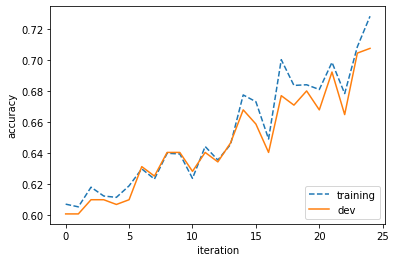

In [432]:
plot_accs(theta_perc_history);

In [208]:
# execute this code to write the predictions on the dev and training data
y_hat_dv = classifier_base.predict_all(x_dv_pruned,theta_perc,labels)
evaluation.write_predictions(y_hat_dv,'perc-dev.preds')
y_hat_te = classifier_base.predict_all(x_te_pruned,theta_perc,labels)
evaluation.write_predictions(y_hat_te,'perc-test.preds')

In [209]:
y_hat = evaluation.read_predictions('perc-dev.preds')
print(evaluation.acc(y_hat,y_dv))

0.7073170731707317


# 5. Logistic regression

Total: 17.5 points

You will implement logistic regression in PyTorch.

## 5.1 Converting data to numpy

Numpy is a package for numerical computing in python.

You will need to convert your bag-of-words list of counters to a numpy array. 

- **Deliverable 5.1**: Implement `preprocessing.py:make_numpy()` (5 points)
- **Test**: `test_pytorch/test_d5_1_numpy`
- **Hint**: one approach is to start with `numpy.zeros((height,width))`, and then fill in the cells by iterating through the bag-of-words list

In [210]:
X = np.zeros((4,2))
print(X)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [211]:
X[1,1] = -1
X[2,0] = 1.5
print(X)

[[ 0.   0. ]
 [ 0.  -1. ]
 [ 1.5  0. ]
 [ 0.   0. ]]


In [212]:
reload(preprocessing);

In [213]:
X_tr = preprocessing.make_numpy(x_tr_pruned,vocab)
X_dv = preprocessing.make_numpy(x_dv_pruned,vocab)
X_te = preprocessing.make_numpy(x_te_pruned,vocab)

In [214]:
label_set = sorted(list(set(y_tr)))
print(label_set)

['fake', 'real']


In [215]:
Y_tr = np.array([label_set.index(y_i) for y_i in y_tr])
Y_dv = np.array([label_set.index(y_i) for y_i in y_dv])

In [216]:
len(set(Y_tr))

2

## 5.2 Building a logistic regression model

- **Deliverable 5.2**: Complete `logistic_regression.build_linear` (2.5 points)
- **Test**: `tests/test_pytorch.py:test_d5_2_logreg`

In [217]:
from oswegonlp import logistic_regression
reload(logistic_regression);

In [218]:
torch.manual_seed(765);

In [219]:
X_tr_var = Variable(torch.from_numpy(X_tr.astype(np.float32)))
X_dv_var = Variable(torch.from_numpy(X_dv.astype(np.float32)))
X_te_var = Variable(torch.from_numpy(X_te.astype(np.float32)))

It's always a good idea to check the dimensions of your data first.

In [283]:
print(X_tr_var.size())
print(X_dv_var.size())

torch.Size([2287, 744])
torch.Size([328, 744])


In [221]:
model = logistic_regression.build_linear(X_tr,Y_tr)

In [411]:
scores = model.forward(X_dv_var)

## 5.3 Adding a log-softmax layer

We've done it for you in PyTorch. Write your own log-softmax function in numpy and verify the results.

- **Deliverable 5.3**: Complete `logistic_regression.log_softmax` (5 points)
- **Test**: `tests/test_pytorch.py:test_d5_3_log_softmax`

In [223]:
model.add_module('softmax',torch.nn.LogSoftmax(dim=1))

In [224]:
model.forward(X_dv_var)[:3]

tensor([[-0.7258, -0.6615],
        [-0.6662, -0.7208],
        [-0.6720, -0.7148]], grad_fn=<SliceBackward>)

In [225]:
model.forward(X_dv_var)[:3].exp()

tensor([[0.4839, 0.5161],
        [0.5137, 0.4863],
        [0.5107, 0.4893]], grad_fn=<ExpBackward>)

Notice that each row sums up to one.

In [226]:
model.forward(X_dv_var)[:3].exp().sum(dim=1)

tensor([1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)

In [227]:
reload(logistic_regression);

In [228]:
logistic_regression.log_softmax(scores[:3].data.numpy()) 

0 0.710667
0 0.710667
1 0.79331774
1 0.79331774
2 0.743574
2 0.743574


array([[-0.72583902, -0.66149044],
       [-0.66619962, -0.72084099],
       [-0.67197901, -0.71477312]])

These should be very close to the PyTorch results.

## 5.4 Negative Log-Likelihood Loss

A loss function tells you how well your model is doing. It produces gradients that allows the optimizer to tune the model weights. We've done the Pytorch call for you, try implementing this yourself in numpy!

- **Deliverable 5.4**: Complete `logistic_regression.nll_loss` (2.5 points)
- **Test**: `tests/test_pytorch.py:test_d5_4_nll_loss`

In [229]:
loss = torch.nn.NLLLoss()

In [230]:
Y_tr_var = Variable(torch.from_numpy(Y_tr))
Y_dv_var = Variable(torch.from_numpy(Y_dv))

In [231]:
logP = model.forward(X_tr_var)
print(loss.forward(logP,Y_tr_var))

tensor(0.6930, grad_fn=<NllLossBackward>)


In [232]:
reload(logistic_regression);

In [233]:
logistic_regression.nll_loss(logP.data.numpy(), Y_tr)

0.6929905418230031

Again, This should be very similar to the PyTorch result above.

## 5.5 Putting everything together

An optimizer can be used to actually learn the weights. We provide the complete code below that you can train on in `logistic_regression.train_model`.

In [234]:
reload(logistic_regression);

In [235]:
# build a new model with a fixed seed
torch.manual_seed(765)
model = logistic_regression.build_linear(X_tr,Y_tr)
model.add_module('softmax',torch.nn.LogSoftmax(dim=1))

In [236]:
model_trained, losses, accuracies = logistic_regression.train_model(loss,model,
                                                       X_tr_var,
                                                       Y_tr_var,
                                                       X_dv_var=X_dv_var,
                                                       Y_dv_var = Y_dv_var,
                                                       num_its=100,
                                                       optim_args={'lr':0.02})

Epoch 1: Dev Accuracy: 0.4817073170731707
Epoch 11: Dev Accuracy: 0.6402439024390244
Epoch 21: Dev Accuracy: 0.676829268292683
Epoch 31: Dev Accuracy: 0.6676829268292683
Epoch 41: Dev Accuracy: 0.6554878048780488
Epoch 51: Dev Accuracy: 0.6585365853658537
Epoch 61: Dev Accuracy: 0.6615853658536586
Epoch 71: Dev Accuracy: 0.6615853658536586
Epoch 81: Dev Accuracy: 0.6676829268292683
Epoch 91: Dev Accuracy: 0.6707317073170732


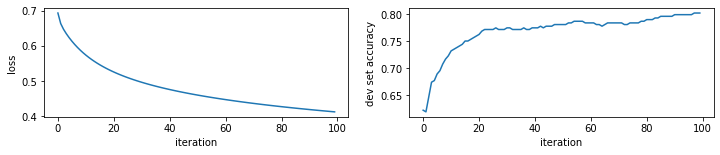

In [278]:
logistic_regression.plot_results(losses,accuracies)

**Deliverable 5.5**
The dev set accuracy drop suggests that something is wrong with our hyperparameters. Tune the inputs to `train_model` until you can get to a dev set accuracy of at least 0.8. (2.5 points)

In [331]:
# build a new model with a fixed seed
torch.manual_seed(765)
model = logistic_regression.build_linear(X_tr,Y_tr)
model.add_module('softmax',torch.nn.LogSoftmax(dim=1))

In [ ]:
model_trained, losses, accuracies = logistic_regression.train_model(loss,model,
                                                       X_tr_var,
                                                       Y_tr_var,
                                                       X_dv_var=X_dv_var,
                                                       Y_dv_var = Y_dv_var,
                                                       num_its=100,
                                                       optim_args={'lr':0.02})

In [333]:
_, Y_hat_dv = model_trained.forward(X_dv_var).max(dim=1)
np.save('logreg-es-dev.preds.npy', Y_hat_dv.data.numpy())

In [334]:
acc = evaluation.acc(np.load('logreg-es-dev.preds.npy'),Y_dv_var.data.numpy())
print(acc)

0.801829268292683


In [270]:
_, Y_hat_te = model.forward(X_te_var).max(dim=1)
np.save('logreg-es-test.preds.npy', Y_hat_te.data.numpy())

In [271]:
# You can't run this
Y_te = np.array([label_set.index(y_i) for y_i in y_te])
Y_te_var = Variable(torch.from_numpy(Y_te))
acc = evaluation.acc(np.load('logreg-es-test.preds.npy'),Y_te_var.data.numpy())
print(acc)

0.82642089093702


# 6. Feature analysis

Total: 8 points


## 6.1 Top Features for Naive Bayes and Perceptron

- **Deliverable 6.1**: Implement ```get_top_features_for_label_numpy``` in ```features.py```. (4 points)
- **Test**: `tests/test_features.py:test_d6_1_topfeat_numpy`

In [250]:
from oswegonlp import features
reload(features);

In [251]:
features.get_top_features_for_label_numpy(theta_perc,'real',7)

[(('real', '**OFFSET**'), 8.0),
 (('real', 'trumps'), 7.0),
 (('real', 'making'), 7.0),
 (('real', 'listen'), 6.0),
 (('real', 'time'), 5.0),
 (('real', 'g'), 5.0),
 (('real', 'even'), 5.0)]

In [252]:
features.get_top_features_for_label_numpy(theta_perc,'fake',7)

[(('fake', 'machines'), 7.0),
 (('fake', 'was'), 6.0),
 (('fake', 'landslide'), 6.0),
 (('fake', 'this'), 6.0),
 (('fake', 'middle'), 6.0),
 (('fake', 'victory'), 5.0),
 (('fake', 'will'), 5.0)]

## 6.2 Top Features for Logistic Regression

- **Deliverable 6.2**: Implement ```get_top_features_for_label_torch``` in ```features.py```. (4 points)
- **Test**: `tests/test_features.py:test_d6_2_topfeat_torch`

**Hint**: Extract linear layer weights from the PyTorch model.

In [335]:
reload(features);

Load a fixed model so we have reproducible results. Feel free to change it to your own model.

In [336]:
model_test = torch.load('tests/test_weights.torch')
print(model_test[0])

Linear(in_features=744, out_features=2, bias=True)


In [337]:
features.get_top_features_for_label_torch(model_test, vocab, label_set,'real',10)

['australia',
 'turnbull',
 'travel',
 'korea',
 'ban',
 'north',
 'says',
 'us',
 'donald',
 'trumps']

In [338]:
features.get_top_features_for_label_torch(model_test, vocab, label_set,'fake',10)

['that', 'of', 'it', 'you', 'is', 'and', 'just', 'a', 'the', 'hillary']

# 7. Competition

Total: 10 points

Try to get the best accuracy possible. 

Some ideas:

- Better features than just bag of words
- Better optimization
- Better classifier, e.g. multilayer neural networks
- Better loss function
- Better preprocessing
- Dropout or other regularization scheme

My current best accuracies are 86.7% dev, 87.3% test. The only thing you can't use is length of headline because our dataset truncates some headlines.

### Rubric

Dev set
- $\geq 86\%$: 5 points
- $\geq 85\%$: 3.75 points
- $\geq 84\%$: 2.5 points
- $\geq 83.5\%$: 1.25 points

Test set
- $\geq 86\%$: 5 point
- $\geq 85\%$: 3.75 points
- $\geq 84.5\%$: 2.5 points
- $\geq 84\%$: 1.25 points
    
### Extra credit
- Extra credit will be given to the top three submissions, by **test set** performance: 10 points, 7.5 points, 5 points. 
- Another 10 points of extra credit will be awarded to submissions that are better than my system, on the test set.
- I will continue to try to improve my results until the deadline, but will not tune on test set accuracy. The below blocks may help in figuring out how to save your competition results.

In [110]:
reload(features);

In [355]:
_, Y_hat_dv = model.forward(X_dv_var).max(dim=1)
np.save('competition-dev.preds.npy', Y_hat_dv.data.numpy())
evaluation.acc(np.load('competition-dev.preds.npy'), Y_dv_var.data.numpy())

0.8170731707317073

In [356]:
_, Y_hat_te = model.forward(X_te_var).max(dim=1)
np.save('competition-test.preds.npy', Y_hat_te.data.numpy())

In [357]:
# You can't run this
evaluation.acc(np.load('competition-test.preds.npy'), Y_te_var.data.numpy())

0.82642089093702